In [355]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [356]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [357]:
# %load Structural_Perturbations.py


# In[1]:


import cv2
import numpy as np
import tensorflow as tf


# In[2]:


def Exposure(eval_data,e):
    e = e/255
    for i in range(0,eval_data.shape[0]):
        eval_data[i][0:eval_data.shape[1] - 4]+=e
        eval_data[i] = eval_data[i].clip(min=0,max=1)
    return eval_data


# In[3]:


def Translation(eval_data,l):
    temp = np.asarray(eval_data)
    temp = np.reshape(temp,(-1,28,28))
    M = np.float32([[1,0,l],[0,1,0]])
    for i in range(0,eval_data.shape[0]):
        temp[i] = cv2.warpAffine(temp[i],M,(28,28))
        temp[i] = temp[i].clip(min=0,max=1)
    temp = np.reshape(temp,[eval_data.shape[0],eval_data.shape[1]])
    eval_data = temp
    return eval_data


# In[4]:


def Rotation(eval_data,angle):
    temp = eval_data.reshape(-1,28,28)
    s,r,c = temp.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),angle,1)
    for i in range (0,s):
        temp[i] = cv2.warpAffine(temp[i],M,(c,r))
        temp[i] = temp[i].clip(min=0,max=1)
    return temp.reshape(-1,eval_data.shape[1])


# In[5]:


def Scaling(eval_data,l):
    temp = eval_data.reshape(-1,28,28)
    s,r,c = temp.shape
    for i in range (0,s):
        img = cv2.resize(temp[i],None,fx=l, fy=l, interpolation = cv2.INTER_CUBIC)
        m = np.int((img.shape[0]-28)/2)
        temp[i] = img[m:m+28,m:m+28]
        temp[i] = temp[i].clip(min=0,max=1)
    return temp.reshape(-1,eval_data.shape[1])


# In[6]:


def Display(eval_data,t):
    l = np.array(eval_data[t])
    l = [int (x * 255) for x in l]
    l = np.asarray(l)
    l = np.reshape(l,(-1,28))
    plt.imshow(l,cmap='gray')


# In[7]:


def Plot(eval_data,eval_labels,mnist_classifier):
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    pred = mnist_classifier.predict(input_fn=eval_input_fn)
    my_array = []
    for i, x in enumerate(pred):
        temp = x['probabilities']
        pos = sorted(temp,reverse=True)
        index = [pos.index(v) for v in temp]
        my_array.append(index[eval_labels[i]])
    count = collections.Counter(my_array)
    keys = np.array(list(count.keys()))
    values = np.array(list(count.values()))
    grid = []
    for i in range(0,keys.shape[0]):
        grid.append([keys[i],values[i]])
    grid = np.array(grid)
    grid.view('i8,i8').sort(axis=0)
    plt.plot(grid)


# In[8]:


def Test(train_data,train_labels,eval_data,eval_labels,mnist_classifier):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=mnist_classifier.evaluate(input_fn=train_eval_input_fn)
    print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=mnist_classifier.evaluate(input_fn=eval_input_fn)
    print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()



In [358]:
avg = np.average(train_data)
def Exp_def(data):
    temp = data
    local_avg = np.average(temp)
    temp = temp + avg - local_avg
    return temp

In [359]:
def reference_image():
    data = np.empty([train_data.shape[0],train_data.shape[1]+1])
    for i in range (0,data.shape[0]):
        data[i] = np.append(train_data[i],int(train_labels[i]))
    data = data[data[:,784].argsort()]
    a = 0.0
    count=[]
    for i in range (0,data.shape[0]):
        if data[i,784]!= a:
            count.append(i)
            a += 1
    count.append(data.shape[0]-1)
    count = np.array(count)
    a = 0
    temp = []
    s = 0
    while a!=count.shape[0]:
        temp.append(data[s:count[a]])
        s = count[a]
        a +=1
    temp = np.array(temp)
    for i in range(0,temp.shape[0]):
        temp[i] = np.delete(temp[i],[784], axis=1)
    avr = np.empty([temp.shape[0],28,28])
    for i in range(0,temp.shape[0]):
        temp[i] = temp[i].reshape(-1,28,28)
        avr[i] = np.median(temp[i],axis=0)
    avr = np.array(avr)
    return avr

In [360]:
# print (np.asarray((unique, counts)).T)
#print(train_data.shape)
ref = reference_image()

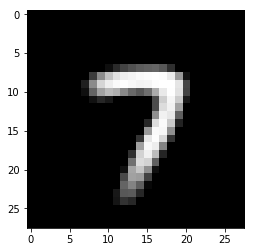

In [181]:
plt.imshow(ref[7],cmap='gray')

In [361]:
def Scale_def(data):
    l = np.array(data)
    l = [int (x * 255) for x in l]
    l = np.asarray(l)
    data = np.reshape(l,(-1,28))
    m = 10
    data = data.reshape(28,28)
    co_ord = []
    x = 20
    for i in range (0,28):
        for j in range (0,28):
            if data[i][j] >= m:
                co_ord.append([i,j])
                x = 1
                break
            if x==1:
                break
    x = 0
    for i in range (0,28):
        for j in range (0,28):
            if data[j][i] >= m:
                co_ord.append([j,i])
                x = 1
                break
            if x==1:
                break
    x = 0
    for i in range (0,28):
        for j in range (0,28):
            if data[27 - i][27 - j] >= m:
                co_ord.append([27 - i,27 - j])
                x = 1
                break
            if x==1:
                break
    x = 0
    for i in range (0,28):
        for j in range (0,28):
            if data[27 - j][27 - i] >= m:
                co_ord.append([27 - j,27 - i])
                x = 1
                break
            if x==1:
                break
    co_ord = np.array(co_ord)
    dist = distance.euclidean(co_ord[0],co_ord[2]),distance.euclidean(co_ord[1],co_ord[3])
    #print(co_ord)
    return dist[0]/dist[1]

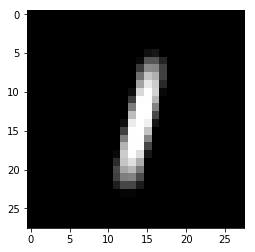

In [362]:
ref = ref.reshape(10,784)
Display(ref,1)

In [363]:
scal1 = np.empty(ref.shape[0])
for i in range (0,ref.shape[0]):
    scal1[i] = Scale_def(ref[i])
print(scal1)

[1.12318229 1.46025783 1.20185043 1.42213639 1.05266714 0.93896582
 1.29389231 1.31245699 1.26841984 1.36963952]


In [364]:
ref = Scaling(ref,1.3)

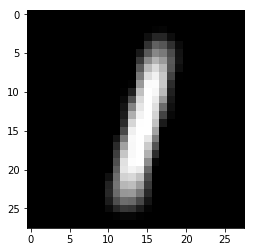

In [365]:
Display(ref,1)

In [366]:
scal2 = np.empty(ref.shape[0])
for i in range (0,ref.shape[0]):
    scal2[i] = Scale_def(ref[i].reshape(784))
print(scal2)

[1.13169683 1.32321673 1.26578432 1.48933569 1.05709492 1.03161048
 1.28072007 1.23163431 1.29167914 1.36438208]


0.13704109906837791


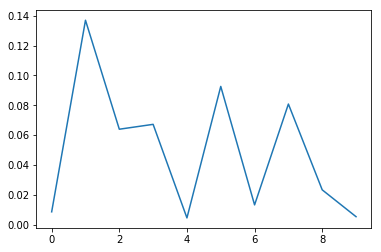

In [367]:
d = np.abs(scal1-scal2)
# for i in range (0,ref.shape[0]):
#     print(i,scal1[i],scal2[i],d[i])
#     print("\n")
print(d[1])
plt.plot(np.arange(0,ref.shape[0]),d)